In [1]:
# Initial imports
import numpy as np
import pandas as pd
from stockstats import StockDataFrame as sdf
import requests
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np
import alpaca_trade_api as tradeapi
from pathlib import Path
import lib_copy
%matplotlib inline

In [ ]:
load_dotenv()

In [ ]:


df = lib_copy.fetch_ohlcv("JPM", "2017-01-01", "2019-01-01")


In [ ]:
def adding_boll_kelt_ewma_dataframe(dataframe):
    lib_copy.bollinger_band_generator(dataframe)
    lib_copy.keltner_channel(dataframe)
    lib_copy.ewma(dataframe)

    return dataframe

In [ ]:
everything = adding_boll_kelt_ewma_dataframe(df)

In [ ]:
# Looking for missing values
everything.isnull().sum().sum()

In [ ]:
# Filling missing values with the previous ones
everything = df.dropna()
everything

In [ ]:
response_data = lib_copy.signals_generator(everything)

response_data.index = response_data.index.date
final_df = response_data
final_df

In [ ]:
"""practice logic

merge actual cross and actual squeeze DF's
carolina's_df = pd.Concatenate(ewma_cross, squeeze)

feed merged df into jonathans target function using 1+1 = 2 target mechanism

use lstm model: utilizing the squeeze and the ewma cross as features and the target as the target

spit out graph

"""


In [ ]:
X = final_df.iloc[:, 0:20].values
y = final_df.iloc[:, :1].values

X, y = np.array(X), np.array(y).reshape(-1,1)

In [ ]:
print (f"X sample values:\n{X[:3]} \n")
print (f"X sample values:\n{y[:3]} \n")


In [ ]:
# Manually splitting the data
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [ ]:
# Importing the MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the features data X
scaler.fit(X)

# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the MinMaxScaler object with the target data Y
scaler.fit(y)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [ ]:
# Reshape the features data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print some sample data after reshaping the datasets
print (f"X_train sample values:\n{X_train[:3]} \n")
print (f"X_test sample values:\n{X_test[:3]}")

In [ ]:
# Importing required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [ ]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [ ]:
# Show the model summary
model.summary()

In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=90, verbose=1)

In [ ]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=0)

In [ ]:
# Make predictions using the testing data X_test
predicted = model.predict(X_test)

In [ ]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = final_df.index[-len(real_prices): ]) 

# Show the DataFrame's head
stocks.head()

In [ ]:
# Plot the real vs predicted prices as a line chart
stocks.plot(title="Actual Vs. Predicted  Prices")

In [ ]:
price = pd.DataFrame(stocks)
price

In [ ]:
fast_ema = 9
slow_ema = 21

In [ ]:
# create EMAs columns
price['pEMA9'] = price['Predicted'].ewm(span=fast_ema, adjust=False).mean()
price['pEMA21'] = price['Predicted'].ewm(span=slow_ema, adjust=False).mean()
price['aEMA9'] = price['Actual'].ewm(span=fast_ema, adjust=False).mean()
price['aEMA21'] = price['Actual'].ewm(span=slow_ema, adjust=False).mean()
# price['compEMAS'] = 0.0
price.plot()

In [ ]:
price.pct_change().plot()

In [ ]:
# Initial imports
import numpy as np
import pandas as pd
from stockstats import StockDataFrame as sdf
import requests
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np
import alpaca_trade_api as tradeapi
from pathlib import Path
import lib_copy
load_dotenv()
%matplotlib inline

ticker_symbol = ["TSLA"]

In [ ]:
X = final_df.iloc[:, 0:20].values
y = final_df.iloc[:, -1].values

X, y = np.array(X), np.array(y).reshape(-1,1)

In [ ]:
dataframe = lib_copy.fetch_ohlcv(ticker_symbol)
def adding_boll_kelt_ewma_dataframe(dataframe):
    lib_copy.bollinger_band_generator(dataframe)
    lib_copy.keltner_channel(dataframe)
    lib_copy.ewma(dataframe)

    return dataframe

everything = adding_boll_kelt_ewma_dataframe(dataframe)

everything = df.dropna()

response_data = lib_copy.signals_generator(everything)

response_data.index = response_data.index.date
final_df = response_data

In [ ]:
def lstm(
    dataframe,
    num_feature_cols = 2, 
    target_name = "target",
    epochs_num = 10,
    unit_number = 30,
    dropout_fraction=.2    
    ):

    """
    Make sure to have target in last column
    """

    X = dataframe.iloc[:, 0:num_feature_cols].values
    
    y = dataframe.iloc[:,-1].values
    
    X, y = np.array(X), np.array(y).reshape(-1,1)

    # Manually splitting the data
    split = int(0.7 * len(X))

    X_train = X[: split]
    X_test = X[split:]

    y_train = y[: split]
    y_test = y[split:]

    # Importing the MinMaxScaler from sklearn
    from sklearn.preprocessing import MinMaxScaler

    # Create a MinMaxScaler object
    scaler = MinMaxScaler()

    # Fit the MinMaxScaler object with the features data X
    scaler.fit(X)

    # Scale the features training and testing sets
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # Fit the MinMaxScaler object with the target data Y
    scaler.fit(y)

    # Scale the target training and testing sets
    y_train = scaler.transform(y_train)
    y_test = scaler.transform(y_test)

    # Importing required Keras modules
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout

    # Define the LSTM RNN model.
    model = Sequential()

    # Layer 1
    model.add(LSTM(
        units=unit_number,
        return_sequences=True,
        input_shape=(X_train.shape[1], 1))
        )
    model.add(Dropout(dropout_fraction))

    # Layer 2
    model.add(LSTM(units=number_units, return_sequences=True))
    model.add(Dropout(dropout_fraction))

    # Layer 3
    model.add(LSTM(units=number_units))
    model.add(Dropout(dropout_fraction))

    # Output layer
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer="adam", loss="mean_squared_error")

    # Train the model
    model.fit(X_train, y_train, epochs= epechs_num, shuffle=False, batch_size=90, verbose=1)

    # Make predictions using the testing data X_test
    predicted = model.predict(X_test)

    # Recover the original prices instead of the scaled version
    predicted_prices = scaler.inverse_transform(predicted)
    real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))
    # Create a DataFrame of Real and Predicted values
    comparison = pd.DataFrame({
        "Actual Target": real_prices.ravel(),
        "Predicted Target": predicted_prices.ravel()
    }, index = dataframe.index[-len(real_prices): ]) 

    return model.summary(), model.evaluate(X_test, y_test, verbose=0), comparison.plot()

In [2]:
beautiful_csv = pd.read_csv("Resources/ts_emax_x_squeeze.csv", parse_dates=[['Date', 'Time']])
beautiful_csv.set_index("Date_Time", inplace=True)
df = beautiful_csv[["squeeze", "emax_signal"]]
df.head()

,squeeze,emax_signal
Date_Time,,
2018-01-12 08:45:00,0,0
2018-01-12 09:00:00,0,0
2018-01-12 09:15:00,0,0
2018-01-12 09:30:00,0,0
2018-01-12 09:45:00,0,0


In [3]:
def target_generator(dataframe_name, col_name1, col_name2, target_col_name):
    """Creates a target for long position
    Args:
        dataframe_name (dict): Dataframe containing indicator data (0's and 1's)
        col_name1 (str): Name of first column name in dataframe to use for calculation
        col_name2 (str): Name of second column name in dataframe to use for calculation
        target_col_name (str): Name of target column name to create and store target values
    Returns:
        A dataframe of:
            original data passed to function,
            appended target column signals of type float (2.0, 1.0, 0.0)
    """
    
    # Target generation
    for index, row in dataframe_name.iterrows():
        dataframe_name.loc[index, target_col_name] = row[col_name1] + row[col_name2]

    # Return dataframe with features and target
    return dataframe_name

In [4]:
new_df = target_generator(df, "squeeze", "emax_signal", "target")
new_df.head()

,squeeze,emax_signal,target
Date_Time,,,
2018-01-12 08:45:00,0,0,0.0
2018-01-12 09:00:00,0,0,0.0
2018-01-12 09:15:00,0,0,0.0
2018-01-12 09:30:00,0,0,0.0
2018-01-12 09:45:00,0,0,0.0


In [5]:
new_df.to_csv("Resources/LSTM_target_list1.csv")

In [51]:
def lstm1(
    dataframe,
    num_feature_cols = 2, 
    target_name = "target",
    epochs_num = 10,
    unit_number = 30,
    dropout_fraction=.2    
    ):

    """
    Make sure to have target in last column
    """

    # Manually splitting the data

    # Construct training start and training end dates

    training_start = dataframe.index.min().strftime(format='%Y-%m-%d')
    training_end = '2019-01-11'

    # Construct test start and test end dates

    testing_start = '2019-01-12'
    testing_end = '2019-06-12'

    # Construct validating start and validating end dates

    vali_start = '2019-06-13'
    vali_end = '2020-01-12'

    # Construct the X_train and y_train datasets
    X_train = dataframe[["squeeze", "emax_signal"]][training_start:training_end]
    y_train = dataframe["target"][training_start:training_end]

    X_test = dataframe[["squeeze", "emax_signal"]][testing_start:testing_end]
    y_test = dataframe["target"][testing_start:testing_end]

    
    #X = dataframe.iloc[:, 0:num_feature_cols].values
    
    #y = dataframe.iloc[:,-1].values

    #X, y = np.array(X), np.array(y).reshape(-1,1)

    # Importing the MinMaxScaler from sklearn
    from sklearn.preprocessing import MinMaxScaler

    # Create a MinMaxScaler object
    scaler = MinMaxScaler()

    # Fit the MinMaxScaler object with the features data X
    scaler.fit(X_train)

    # Scale the features training and testing sets
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    y_train = y_train.values.reshape(-1,1)
    y_test = y_test.values.reshape(-1,1)

    # Fit the MinMaxScaler object with the target data Y
    scaler.fit(y_train)

    # Scale the target training and testing sets
    y_train = scaler.transform(y_train)
    y_test = scaler.transform(y_test)

    
    
    # Importing required Keras modules
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout

    # Define the LSTM RNN model.
    model = Sequential()
    X_train = X_train.reshape(-1,1,2)
    X_test = X_test.reshape(-1,1,2)    
    print(X_train[1])
    # Layer 1
    model.add(LSTM(
        units=unit_number,
        return_sequences=True,
        input_shape=(1,2)))
        
    model.add(Dropout(dropout_fraction))

    # Layer 2
    model.add(LSTM(units=unit_number, return_sequences=True))
    model.add(Dropout(dropout_fraction))

    # Layer 3
    model.add(LSTM(units=unit_number, return_sequences=True))
    model.add(Dropout(dropout_fraction))

    # Output layer
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer="adam", loss="mean_squared_error")
    
    print(model.summary())
    # Train the model
    model.fit(X_train, y_train, epochs= epochs_num, shuffle=False, batch_size=90, verbose=1)

    # Make predictions using the testing data X_test
    predicted = model.predict(X_test)
    print(predicted)
    # Recover the original prices instead of the scaled version
    predicted_prices = scaler.inverse_transform(predicted.reshape(-1,1))
    real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))
    # Create a DataFrame of Real and Predicted values
    comparison = pd.DataFrame({
        "Actual Target": real_prices.ravel(),
        "Predicted Target": predicted_prices.ravel()
    }, index = dataframe.index[-len(real_prices): ]) 

    return model.summary(), model.evaluate(X_test, y_test, verbose=0), comparison.plot()

[[0.  0.5]]
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_43 (LSTM)               (None, 1, 30)             3960      
_________________________________________________________________
dropout_40 (Dropout)         (None, 1, 30)             0         
_________________________________________________________________
lstm_44 (LSTM)               (None, 1, 30)             7320      
_________________________________________________________________
dropout_41 (Dropout)         (None, 1, 30)             0         
_________________________________________________________________
lstm_45 (LSTM)               (None, 1, 30)             7320      
_________________________________________________________________
dropout_42 (Dropout)         (None, 1, 30)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 1, 1)

(None,
 0.009914685040712357,
 <matplotlib.axes._subplots.AxesSubplot at 0x14f0d5700>)

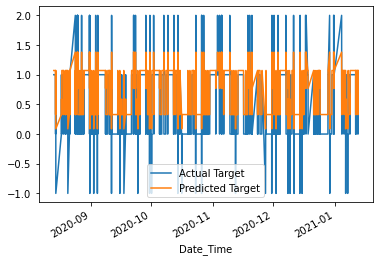

In [52]:
lstm1(new_df, epochs_num= 1, num_feature_cols=2)